## Wrangle and Analyze Data

Wrangling of WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. 

## Table of Contents
- [Introduction](#intro)
- [Gathering](#gathering)
- [Assessing](#assessing)
    - [The WeRateDogs twitter archive](#weratedogstwitter)
    - [The tweet image predictions](#tweetimagepreductions)
    - [Data retrieved via twitter API](#datafromtwitter)
    - [Synthesis](#assesssynthesis)
- [Cleaning](#cleaning)
- [Storing Cleaned Data](#storing)
- [Analyzing and Visualizing](#analysis)



<a id='intro'></a>
### Introduction

The WeRateDogs Twitter archive is great, but it only contains very basic tweet information. So we perform additional gathering through an URL and a direct connection to twitter. Then we assess and clean the Data as required to perform analysis and visualization.

In [784]:
# Import required packages
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

<a id='gathering'></a>
### Gathering

Based on the project motivation and details, we gather Data from three sources:
1. The WeRateDogs twitter archive, available as `twitter_archive_enhanced.csv`
2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network, available at the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
3. A pandas DataFrame created from data we will be collecting directly from twitter

#### 1. Gather data from the archive available as `twitter-archive-enhanced.csv`

In [785]:
# Load the csv file as a dataframe
df_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [786]:
# make a copy, as we will be using the copy
df_archive_clean = df_archive.copy()

In [787]:
# Get a view on the dataframe
df_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


From the project details, we got the information that the data we loaded are probably not all correct: the ratings are probably not all correct, same for the dog names and dog stages.  
So we will need to assess and clean those columns prior to any analysis and visualization.

#### 2. Gather the tweet image predictions

As the `image-predictions.tsv` is available through the following URL https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv, I download it first using the "Requests" library, and then I load it as a dataframe.

In [5]:
# Set the images file URL
images_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [6]:
# Get the content 
response = requests.get(images_url)

In [7]:
# Write it locally as a file
with open('tweet_images_predictions.tsv', mode='wb') as file:
        file.write(response.content)

In [788]:
# load the images prediction file as a dataframe
df_image = pd.read_csv('tweet_images_predictions.tsv', sep='\t')

In [789]:
# create a copy for our further cleaning
df_image_clean = df_image.copy()

In [790]:
# Get a view to this dataframe
df_image_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 3. Gather additional informations directly from twitter

From the twitter archive data loaded as `df_archive_clean`, "retweet count" and "favorite count" ("like") are missing.  
We gather this additional information using twitter API. Using the tweet IDs within `df_archive_clean` we gather all this missing info through queries towards Twitter's API.  
The gathering process here is the following:
* For each tweet ID in the WeRateDogs archive (`df_archive_clean`),
* We query the Twitter API and get a tweet JSON data
* We store the entire set of JSON data in a file called `tweet_json.txt`, on a new line
* Once `tweet_json.txt` is completed, we read it line by line into a pandas DataFrame (at a minimum with tweet ID, retweet count, favorite count)

In [53]:
# Create twitter API object to gather twitter data
# Get the key, token and secrets
# - keys, token and secrets are hidden here -


# Create the api object
# set the wait_on_rate_limit to True to automatically wait for rate limits to refill
# set wait_on_rate_limit_notify to True to print a notification when Tweepy is waiting for rate limits to refill
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

The next cell query the twitter API and write the content into "tweet_json.txt" file.  
Due to the rate limit from twitter, this code run for more or less 30 minutes !

In [58]:
# Just to keep the tweet IDs with no status found
no_status_tweet_ids = []

# Start code timer
start = timer()

# Create and open a tweet_json.txt file
with open('tweet_json.txt', mode='w') as json_file:
    
    # Iterate over the "tweet_id" column from WeRateDogs twitter archive "df_archive_clean"
    for tweet_id in np.nditer(df_archive_clean.tweet_id):
        
        # Try...except in case some tweets IDs do not lead to any status
        try:
            # Get the object associated with tweet_id
            a_tweet = api.get_status(tweet_id, tweet_mode='extended')
            # Get the tweet JSON info from the object, and write it into a file
            json_file.write(json.dumps(a_tweet._json)+'\n')
        except tweepy.TweepError as e:
            print("Error Tweet_Id: " + str(tweet_id) + " : " + str(e))
            # Keep the Ids with no status found
            no_status_tweet_ids.append(str(tweet_id))
        
        # Print out the tweet ID after it was queried
        print("Successfully queried - Tweet ID: " + str(tweet_id))
        
# End code timer
stop = timer()

Successfully queried - Tweet ID: 892420643555336193
Successfully queried - Tweet ID: 892177421306343426
Successfully queried - Tweet ID: 891815181378084864
Successfully queried - Tweet ID: 891689557279858688
Successfully queried - Tweet ID: 891327558926688256
Successfully queried - Tweet ID: 891087950875897856
Successfully queried - Tweet ID: 890971913173991426
Successfully queried - Tweet ID: 890729181411237888
Successfully queried - Tweet ID: 890609185150312448
Successfully queried - Tweet ID: 890240255349198849
Successfully queried - Tweet ID: 890006608113172480
Successfully queried - Tweet ID: 889880896479866881
Successfully queried - Tweet ID: 889665388333682689
Successfully queried - Tweet ID: 889638837579907072
Successfully queried - Tweet ID: 889531135344209921
Successfully queried - Tweet ID: 889278841981685760
Successfully queried - Tweet ID: 888917238123831296
Successfully queried - Tweet ID: 888804989199671297
Successfully queried - Tweet ID: 888554962724278272
Error Tweet_

Successfully queried - Tweet ID: 863432100342583297
Successfully queried - Tweet ID: 863427515083354112
Successfully queried - Tweet ID: 863079547188785154
Successfully queried - Tweet ID: 863062471531167744
Successfully queried - Tweet ID: 862831371563274240
Successfully queried - Tweet ID: 862722525377298433
Successfully queried - Tweet ID: 862457590147678208
Successfully queried - Tweet ID: 862096992088072192
Error Tweet_Id: 861769973181624320 : [{'code': 144, 'message': 'No status found with that ID.'}]
Successfully queried - Tweet ID: 861769973181624320
Successfully queried - Tweet ID: 861383897657036800
Successfully queried - Tweet ID: 861288531465048066
Successfully queried - Tweet ID: 861005113778896900
Successfully queried - Tweet ID: 860981674716409858
Successfully queried - Tweet ID: 860924035999428608
Successfully queried - Tweet ID: 860563773140209665
Successfully queried - Tweet ID: 860524505164394496
Successfully queried - Tweet ID: 860276583193509888
Successfully querie

Successfully queried - Tweet ID: 837366284874571778
Successfully queried - Tweet ID: 837110210464448512
Error Tweet_Id: 837012587749474308 : [{'code': 144, 'message': 'No status found with that ID.'}]
Successfully queried - Tweet ID: 837012587749474308
Successfully queried - Tweet ID: 836989968035819520
Successfully queried - Tweet ID: 836753516572119041
Successfully queried - Tweet ID: 836677758902222849
Successfully queried - Tweet ID: 836648853927522308
Successfully queried - Tweet ID: 836397794269200385
Successfully queried - Tweet ID: 836380477523124226
Successfully queried - Tweet ID: 836260088725786625
Successfully queried - Tweet ID: 836001077879255040
Successfully queried - Tweet ID: 835685285446955009
Successfully queried - Tweet ID: 835574547218894849
Successfully queried - Tweet ID: 835536468978302976
Successfully queried - Tweet ID: 835309094223372289
Successfully queried - Tweet ID: 835297930240217089
Successfully queried - Tweet ID: 835264098648616962
Successfully querie

Successfully queried - Tweet ID: 818646164899774465
Successfully queried - Tweet ID: 818627210458333184
Successfully queried - Tweet ID: 818614493328580609
Successfully queried - Tweet ID: 818588835076603904
Successfully queried - Tweet ID: 818536468981415936
Successfully queried - Tweet ID: 818307523543449600
Successfully queried - Tweet ID: 818259473185828864
Successfully queried - Tweet ID: 818145370475810820
Successfully queried - Tweet ID: 817908911860748288
Successfully queried - Tweet ID: 817827839487737858
Successfully queried - Tweet ID: 817777686764523521
Successfully queried - Tweet ID: 817536400337801217
Successfully queried - Tweet ID: 817502432452313088
Successfully queried - Tweet ID: 817423860136083457
Successfully queried - Tweet ID: 817415592588222464
Successfully queried - Tweet ID: 817181837579653120
Successfully queried - Tweet ID: 817171292965273600
Successfully queried - Tweet ID: 817120970343411712
Successfully queried - Tweet ID: 817056546584727552
Successfully

Successfully queried - Tweet ID: 798585098161549313
Successfully queried - Tweet ID: 798576900688019456
Successfully queried - Tweet ID: 798340744599797760
Successfully queried - Tweet ID: 798209839306514432
Successfully queried - Tweet ID: 797971864723324932
Successfully queried - Tweet ID: 797545162159308800
Successfully queried - Tweet ID: 797236660651966464
Successfully queried - Tweet ID: 797165961484890113
Successfully queried - Tweet ID: 796904159865868288
Successfully queried - Tweet ID: 796865951799083009
Successfully queried - Tweet ID: 796759840936919040
Successfully queried - Tweet ID: 796563435802726400
Successfully queried - Tweet ID: 796484825502875648
Successfully queried - Tweet ID: 796387464403357696
Successfully queried - Tweet ID: 796177847564038144
Successfully queried - Tweet ID: 796149749086875649
Successfully queried - Tweet ID: 796125600683540480
Successfully queried - Tweet ID: 796116448414461957
Successfully queried - Tweet ID: 796080075804475393
Successfully

Successfully queried - Tweet ID: 778039087836069888
Successfully queried - Tweet ID: 778027034220126208
Successfully queried - Tweet ID: 777953400541634568
Successfully queried - Tweet ID: 777885040357281792
Successfully queried - Tweet ID: 777684233540206592
Successfully queried - Tweet ID: 777641927919427584
Successfully queried - Tweet ID: 777621514455814149
Successfully queried - Tweet ID: 777189768882946048
Successfully queried - Tweet ID: 776819012571455488
Successfully queried - Tweet ID: 776813020089548800
Successfully queried - Tweet ID: 776477788987613185
Successfully queried - Tweet ID: 776249906839351296
Successfully queried - Tweet ID: 776218204058357768
Successfully queried - Tweet ID: 776201521193218049
Successfully queried - Tweet ID: 776113305656188928
Successfully queried - Tweet ID: 776088319444877312
Successfully queried - Tweet ID: 775898661951791106
Successfully queried - Tweet ID: 775842724423557120
Successfully queried - Tweet ID: 775733305207554048
Successfully

Successfully queried - Tweet ID: 756998049151549440
Successfully queried - Tweet ID: 756939218950160384
Successfully queried - Tweet ID: 756651752796094464
Successfully queried - Tweet ID: 756526248105566208
Successfully queried - Tweet ID: 756303284449767430
Successfully queried - Tweet ID: 756288534030475264
Successfully queried - Tweet ID: 756275833623502848
Successfully queried - Tweet ID: 755955933503782912
Successfully queried - Tweet ID: 755206590534418437
Successfully queried - Tweet ID: 755110668769038337
Successfully queried - Tweet ID: 754874841593970688
Successfully queried - Tweet ID: 754856583969079297
Successfully queried - Tweet ID: 754747087846248448
Successfully queried - Tweet ID: 754482103782404096
Successfully queried - Tweet ID: 754449512966619136
Successfully queried - Tweet ID: 754120377874386944
Error Tweet_Id: 754011816964026368 : [{'code': 144, 'message': 'No status found with that ID.'}]
Successfully queried - Tweet ID: 754011816964026368
Successfully querie

Successfully queried - Tweet ID: 739979191639244800
Successfully queried - Tweet ID: 739932936087216128
Successfully queried - Tweet ID: 739844404073074688
Successfully queried - Tweet ID: 739623569819336705
Successfully queried - Tweet ID: 739606147276148736
Successfully queried - Tweet ID: 739544079319588864
Successfully queried - Tweet ID: 739485634323156992
Successfully queried - Tweet ID: 739238157791694849
Successfully queried - Tweet ID: 738891149612572673
Successfully queried - Tweet ID: 738885046782832640
Successfully queried - Tweet ID: 738883359779196928
Successfully queried - Tweet ID: 738537504001953792
Successfully queried - Tweet ID: 738402415918125056
Successfully queried - Tweet ID: 738184450748633089
Successfully queried - Tweet ID: 738166403467907072
Successfully queried - Tweet ID: 738156290900254721
Successfully queried - Tweet ID: 737826014890496000
Successfully queried - Tweet ID: 737800304142471168
Successfully queried - Tweet ID: 737678689543020544
Successfully

Successfully queried - Tweet ID: 713411074226274305
Successfully queried - Tweet ID: 713177543487135744
Successfully queried - Tweet ID: 713175907180089344
Successfully queried - Tweet ID: 712809025985978368
Successfully queried - Tweet ID: 712717840512598017
Successfully queried - Tweet ID: 712668654853337088
Successfully queried - Tweet ID: 712438159032893441
Successfully queried - Tweet ID: 712309440758808576
Successfully queried - Tweet ID: 712097430750289920
Successfully queried - Tweet ID: 712092745624633345
Successfully queried - Tweet ID: 712085617388212225
Successfully queried - Tweet ID: 712065007010385924
Successfully queried - Tweet ID: 711998809858043904
Successfully queried - Tweet ID: 711968124745228288
Successfully queried - Tweet ID: 711743778164514816
Successfully queried - Tweet ID: 711732680602345472
Successfully queried - Tweet ID: 711694788429553666
Successfully queried - Tweet ID: 711652651650457602
Successfully queried - Tweet ID: 711363825979756544
Successfully

Successfully queried - Tweet ID: 700462010979500032
Successfully queried - Tweet ID: 700167517596164096
Successfully queried - Tweet ID: 700151421916807169
Successfully queried - Tweet ID: 700143752053182464
Successfully queried - Tweet ID: 700062718104104960
Successfully queried - Tweet ID: 700029284593901568
Successfully queried - Tweet ID: 700002074055016451
Successfully queried - Tweet ID: 699801817392291840
Successfully queried - Tweet ID: 699788877217865730
Successfully queried - Tweet ID: 699779630832685056
Successfully queried - Tweet ID: 699775878809702401
Successfully queried - Tweet ID: 699691744225525762
Successfully queried - Tweet ID: 699446877801091073
Successfully queried - Tweet ID: 699434518667751424
Successfully queried - Tweet ID: 699423671849451520
Successfully queried - Tweet ID: 699413908797464576
Successfully queried - Tweet ID: 699370870310113280
Successfully queried - Tweet ID: 699323444782047232
Successfully queried - Tweet ID: 699088579889332224
Successfully

Successfully queried - Tweet ID: 689283819090870273
Successfully queried - Tweet ID: 689280876073582592
Successfully queried - Tweet ID: 689275259254616065
Successfully queried - Tweet ID: 689255633275777024
Successfully queried - Tweet ID: 689154315265683456
Successfully queried - Tweet ID: 689143371370250240
Successfully queried - Tweet ID: 688916208532455424
Successfully queried - Tweet ID: 688908934925697024
Successfully queried - Tweet ID: 688898160958271489
Successfully queried - Tweet ID: 688894073864884227
Successfully queried - Tweet ID: 688828561667567616
Successfully queried - Tweet ID: 688804835492233216
Successfully queried - Tweet ID: 688789766343622656
Successfully queried - Tweet ID: 688547210804498433
Successfully queried - Tweet ID: 688519176466644993
Successfully queried - Tweet ID: 688385280030670848
Successfully queried - Tweet ID: 688211956440801280
Successfully queried - Tweet ID: 688179443353796608
Successfully queried - Tweet ID: 688116655151435777
Successfully

Rate limit reached. Sleeping for: 571


Successfully queried - Tweet ID: 683098815881154561
Successfully queried - Tweet ID: 683078886620553216
Successfully queried - Tweet ID: 683030066213818368
Successfully queried - Tweet ID: 682962037429899265
Successfully queried - Tweet ID: 682808988178739200
Successfully queried - Tweet ID: 682788441537560576
Successfully queried - Tweet ID: 682750546109968385
Successfully queried - Tweet ID: 682697186228989953
Successfully queried - Tweet ID: 682662431982772225
Successfully queried - Tweet ID: 682638830361513985
Successfully queried - Tweet ID: 682429480204398592
Successfully queried - Tweet ID: 682406705142087680
Successfully queried - Tweet ID: 682393905736888321
Successfully queried - Tweet ID: 682389078323662849
Successfully queried - Tweet ID: 682303737705140231
Successfully queried - Tweet ID: 682259524040966145
Successfully queried - Tweet ID: 682242692827447297
Successfully queried - Tweet ID: 682088079302213632
Successfully queried - Tweet ID: 682059653698686977
Successfully

Successfully queried - Tweet ID: 676613908052996102
Successfully queried - Tweet ID: 676606785097199616
Successfully queried - Tweet ID: 676603393314578432
Successfully queried - Tweet ID: 676593408224403456
Successfully queried - Tweet ID: 676590572941893632
Successfully queried - Tweet ID: 676588346097852417
Successfully queried - Tweet ID: 676582956622721024
Successfully queried - Tweet ID: 676575501977128964
Successfully queried - Tweet ID: 676533798876651520
Successfully queried - Tweet ID: 676496375194980353
Successfully queried - Tweet ID: 676470639084101634
Successfully queried - Tweet ID: 676440007570247681
Successfully queried - Tweet ID: 676430933382295552
Successfully queried - Tweet ID: 676263575653122048
Successfully queried - Tweet ID: 676237365392908289
Successfully queried - Tweet ID: 676219687039057920
Successfully queried - Tweet ID: 676215927814406144
Successfully queried - Tweet ID: 676191832485810177
Successfully queried - Tweet ID: 676146341966438401
Successfully

Successfully queried - Tweet ID: 673213039743795200
Successfully queried - Tweet ID: 673148804208660480
Successfully queried - Tweet ID: 672997845381865473
Successfully queried - Tweet ID: 672995267319328768
Successfully queried - Tweet ID: 672988786805112832
Successfully queried - Tweet ID: 672984142909456390
Successfully queried - Tweet ID: 672980819271634944
Successfully queried - Tweet ID: 672975131468300288
Successfully queried - Tweet ID: 672970152493887488
Successfully queried - Tweet ID: 672968025906282496
Successfully queried - Tweet ID: 672964561327235073
Successfully queried - Tweet ID: 672902681409806336
Successfully queried - Tweet ID: 672898206762672129
Successfully queried - Tweet ID: 672884426393653248
Successfully queried - Tweet ID: 672877615439593473
Successfully queried - Tweet ID: 672834301050937345
Successfully queried - Tweet ID: 672828477930868736
Successfully queried - Tweet ID: 672640509974827008
Successfully queried - Tweet ID: 672622327801233409
Successfully

Successfully queried - Tweet ID: 670086499208155136
Successfully queried - Tweet ID: 670079681849372674
Successfully queried - Tweet ID: 670073503555706880
Successfully queried - Tweet ID: 670069087419133954
Successfully queried - Tweet ID: 670061506722140161
Successfully queried - Tweet ID: 670055038660800512
Successfully queried - Tweet ID: 670046952931721218
Successfully queried - Tweet ID: 670040295598354432
Successfully queried - Tweet ID: 670037189829525505
Successfully queried - Tweet ID: 670003130994700288
Successfully queried - Tweet ID: 669993076832759809
Successfully queried - Tweet ID: 669972011175813120
Successfully queried - Tweet ID: 669970042633789440
Successfully queried - Tweet ID: 669942763794931712
Successfully queried - Tweet ID: 669926384437997569
Successfully queried - Tweet ID: 669923323644657664
Successfully queried - Tweet ID: 669753178989142016
Successfully queried - Tweet ID: 669749430875258880
Successfully queried - Tweet ID: 669684865554620416
Successfully

Successfully queried - Tweet ID: 667174963120574464
Successfully queried - Tweet ID: 667171260800061440
Successfully queried - Tweet ID: 667165590075940865
Successfully queried - Tweet ID: 667160273090932737
Successfully queried - Tweet ID: 667152164079423490
Successfully queried - Tweet ID: 667138269671505920
Successfully queried - Tweet ID: 667119796878725120
Successfully queried - Tweet ID: 667090893657276420
Successfully queried - Tweet ID: 667073648344346624
Successfully queried - Tweet ID: 667070482143944705
Successfully queried - Tweet ID: 667065535570550784
Successfully queried - Tweet ID: 667062181243039745
Successfully queried - Tweet ID: 667044094246576128
Successfully queried - Tweet ID: 667012601033924608
Successfully queried - Tweet ID: 666996132027977728
Successfully queried - Tweet ID: 666983947667116034
Successfully queried - Tweet ID: 666837028449972224
Successfully queried - Tweet ID: 666835007768551424
Successfully queried - Tweet ID: 666826780179869698
Successfully

In [61]:
# Get the duration for the whole data collection from twitter
print("Twitter Query and file writing duration: " + str(stop - start))

Twitter Query and file writing duration: 1430.7260451979819


Now as `tweet_json.txt` file has been properly created, we can read it and create the associated pandas DataFrame with at a minimum "tweet ID", "retweet count", and "favorite count" as columns.

In [791]:
# A dictionary to build and convert to a DataFrame later
df_tweet_json = []

We've got a basic understanding of the tweet json object from here : https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html. So I choose to collect "created_at", "id", "retweet_count", "favorite_count" and "full_text".

In [792]:
# Load "tweet_json.txt"
with open('tweet_json.txt') as tweet_json:
    
    # Get each line and load it as a json object
    for a_line in tweet_json:
        line_data_json = json.loads(a_line)
        
        # Get the tweet ID
        tweet_id = line_data_json['id']
        
        # Get the tweet retweet count
        retweet_count = line_data_json['retweet_count']
        
        # Get the tweet favorites count
        favorite_count = line_data_json['favorite_count']
        
        # Get the tweet creation date
        creation_date = line_data_json['created_at']
        
        # Get the tweet full text
        tweet_full_text = line_data_json['full_text']
        
        
        # Add the extracted data to the dictionary
        df_tweet_json.append({'tweet_id': tweet_id,
                            'created_at': creation_date,
                            'retweet_count': retweet_count,
                            'favorite_count': favorite_count,
                            'tweet_full_text': tweet_full_text})

In [793]:
# Convert the dictionary to a DataFrame
df_twitter = pd.DataFrame(df_tweet_json, columns = ['tweet_id', 'created_at', 'retweet_count', 'favorite_count', 'tweet_full_text'])

In [794]:
# Create a copy to use for assessing and cleaning
df_twitter_clean = df_twitter.copy()

In [795]:
# Get a view on the dataframe
df_twitter_clean.head()

,tweet_id,created_at,retweet_count,favorite_count,tweet_full_text
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,8204,37636,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,6071,32337,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,4011,24363,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,8366,40959,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,9063,39161,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f"


At this point, We've got three DataFrames for the next assessment and cleaning activities: 
* `df_archive_clean` : WeRateDogs twitter enhanced archive. We know that the ratings are probably not all correct, same for the dog names and dog stages.
* `df_image_clean` : the tweets images prediction, from `image-predictions.tsv` which we gathered from an URL.
* `df_twitter_clean`: additional information - retweet counts, favorite counts - gathered from twitter because missing from `df_archive_clean`

<a id='assessing'></a>
### Assessing

We focus first on missing data, completness, format as quality issues. Then we examine tidiness.  

<a id='weratedogstwitter'></a>
#### 1. The WeRateDogs twitter archive

Here are the information we already know about `df_archive_clean` : the ratings are probably not all correct, same for the dog names and dog stages. So we'll need to assess those columns.

In [796]:
# Get a view on the dataset
df_archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2147,669753178989142016,NaN,NaN,2015-11-26 05:42:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Chester. He just ate a lot and now he can't move. 10/10 that's going to be me in about 17 hours https://t.co/63jh1tYZa5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669753178989142016/photo/1,10,10,Chester,None,None,None,None
603,798628517273620480,NaN,NaN,2016-11-15 20:47:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,6.675094e+17,4.196984e+09,2015-11-20 01:06:48 +0000,"https://twitter.com/dog_rates/status/667509364010450944/photo/1,https://twitter.com/dog_rates/status/667509364010450944/photo/1",12,10,None,None,None,None,None
2308,666817836334096384,NaN,NaN,2015-11-18 03:18:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jeph. He is a German Boston Shuttlecock. Enjoys couch. Lost body during French Revolution. True hero 9/10 https://t.co/8whlkYw3mO,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666817836334096384/photo/1,9,10,Jeph,None,None,None,None
468,817056546584727552,NaN,NaN,2017-01-05 17:13:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Chloe. She fell asleep at the wheel. Absolute menace on the roadways. Sneaky tongue slip tho. 11/10 https://t.co/r6SLVN2VUH,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817056546584727552/photo/1,11,10,Chloe,None,None,None,None
726,782598640137187329,NaN,NaN,2016-10-02 15:10:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Timmy. He's quite large. According to a trusted source it's actually a dog wearing a dog suit. 11/10 https://t.co/BIUchFwHqn,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782598640137187329/photo/1,11,10,Timmy,None,None,None,None


Elements from a first visual observation:
* "source" column contains html tags. We do not consider this as an issue regarding the analysis we plan to conduct.
* "expanded_urls" contains some duplicated values. 

In [797]:
# Get the dataset size
df_archive_clean.shape

(2356, 17)

In [798]:
# Do we have duplicates ?
sum(df_archive_clean.duplicated())

0

In [799]:
# What about missing data ?
df_archive_clean.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 59  
rating_numerator              0   
rating_denominator            0   
name                          0   
doggo                         0   
floofer                       0   
pupper                        0   
puppo                         0   
dtype: int64

Basically, the rows with data in the "retweeted_status" columns are the ones related to a retweet. As not having retweet is a prerequisite, I will delete all the rows with values in the "retweeted_status*" columns. I will do the same for the "reply_to" columns. Following to that, I will delete those columns because those will not be useful anymore.

#### Quality Issue 1 : The WeRateDgos twitter archive enhanced contains retweets, which could not be part or our study 

We observe 59 missing expanded_urls. 
#### Quality Issue 2 : The WeRateDgos twitter archive enhanced has 59 missing value from the "expanded_urls" column

Now, let's check the unique values for some columns, the ones we are most likely to use further.

In [800]:
# Get the unique values for rating numerator, as we knew we might have issues there
df_archive_clean.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [801]:
# is the 0 value a normal situation ?
df_archive_clean.query('rating_numerator == 0')[['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
315,0,10,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
1016,0,10,"PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX"


We've got some very high values ! let's check the context to see if this situation really makes sense.

In [802]:
# Set the column width to max, so we can easily view all the cells text data
pd.set_option('display.max_colwidth', -1)

In [803]:
# Get the cases with a suspicious denominator so we can observe them visually
df_denominator_issues = df_archive_clean.query('rating_denominator != 10')[['rating_numerator', 'rating_denominator', 'text']]
df_denominator_issues

,rating_numerator,rating_denominator,text
313,960,0,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"
342,11,15,@docmisterio account started on 11/15/15
433,84,70,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784,9,11,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…"
902,165,150,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1068,9,11,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ"
1120,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1165,4,20,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1202,50,50,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq


We observe :
* One case where the extracted information - 24/7 - is not a rating 
* Normal situations, as previously observed : the denominator is high but inline with the numerator value
* Other situations where the first "rating like" values encountered have been extracted instead of the second ones. For example we see a line where 50/50 have been extracted instead of 11/10, which is the real rating within the same text message. 

#### Quality Issue 4 : WeRateDgos twitter archive - in some cases, the relevant rating information, consequently rating_numerator and rating_denominator, have not been extracted.

We continue to check unique values for some columns.  
Visually, we saw "none" as dog names. Let's dig in that.

In [804]:
# Check the dog names, as we might have issues there. We get 20 rows for a visual observation
df_name_issues = df_archive_clean.query('name == "None"')[['name', 'text']]
df_name_issues.sample(20)

,name,text
1928,None,Herd of wild dogs here. Not sure what they're trying to do. No real goals in life. 3/10 find your purpose puppers https://t.co/t5ih0VrK02
2013,None,Exotic underwater dog here. Very shy. Wont return tennis balls I toss him. Never been petted. 5/10 I bet he's soft https://t.co/WH7Nzc5IBA
1783,None,Endangered triangular pup here. Could be a wizard. Caught mid-laugh. No legs. Just fluff. Probably a wizard. 9/10 https://t.co/GFVIHIod0Z
2067,None,Neat pup here. Enjoys lettuce. Long af ears. Short lil legs. Hops surprisingly high for dog. 9/10 still very petable https://t.co/HYR611wiA4
494,None,We only rate dogs. Please don't send in other things like this very good Christmas tree. Thank you... 13/10 https://t.co/rvSANEsQZJ
1408,None,ERMAHGERD 12/10 please enjoy https://t.co/7WrAWKdBac
212,None,RT @eddie_coe98: Thanks @dog_rates completed my laptop. 10/10 would buy again https://t.co/bO0rThDlXI
179,None,@Marc_IRL pixelated af 12/10
2131,None,"""Hi yes this is dog. I can't help with that s- sir please... the manager isn't in right n- well that was rude""\n10/10 https://t.co/DuQXATW27f"
1935,None,This pup is sad bc he didn't get to be the toy car. Also he has shitty money management skills. 10/10 still cute tho https://t.co/PiSXXZjDSJ


We observe that sometimes we have names in the text, so we still have the possibility to extract them. For example, at index 72, we could have "Martha", at index 2237, we have "Oliver". 
The "None" here as a string could be confusing. We do not consider this as an issue. Basically we just want to be able to distinguish when we do have a name, from when we don't.  
#### Quality Issue 5 : WeRateDgos twitter archive - We have "None" as name even if, sometimes, there is an available name in the text. So few names are missing and could be retrieved.

We observe "None" values in the dog stages "doggo, floofer, pupper, puppo" columns.

In [805]:
# Get all the rows where the dog stage has not been identified, meaning set to "None"
df_dogtionary_issue = df_archive_clean.query('doggo == "None" and floofer == "None" and pupper == "None" and puppo == "None"')[['text', 'doggo', 'floofer', 'pupper', 'puppo']]
df_dogtionary_issue.shape

(1976, 5)

In [806]:
# Do we have any puppo in the associated text content ? meaning not identified ?
df_dogtionary_issue['text'].apply(lambda x: ('puppo' in x)).value_counts()

False    1969
True     7   
Name: text, dtype: int64

In [807]:
# Do we have any doggo in the associated text content ? meaning not identified ?
df_dogtionary_issue['text'].apply(lambda x: ('doggo' in x)).value_counts()

False    1966
True     10  
Name: text, dtype: int64

In [808]:
# Do we have any floofer in the associated text content ? meaning not identified ?
df_dogtionary_issue['text'].apply(lambda x: ('floofer' in x)).value_counts()

False    1976
Name: text, dtype: int64

In [809]:
# Do we have any pupper in the associated text content ? meaning not identified ?
df_dogtionary_issue['text'].apply(lambda x: ('pupper' in x)).value_counts()

False    1952
True     24  
Name: text, dtype: int64

As a conclusion, we have a quality issue. Clearly we have the possibility to have several dog stages within the same text. So the stage extrated might not be the right one, sometimes. We do not consider this as an issue, because of the potential low number of rows impacted.  
#### Quality Issue 6 : WeRateDgos twitter archive - We have missing dog stages, meaning stages not properly extracted. This is the case for "puppo", "doggo" and "pupper".

In [810]:
# Check the duplicated expanded_urls we observed previously
df_archive_clean['expanded_urls'].str.contains(',').value_counts()

False    1658
True     639 
Name: expanded_urls, dtype: int64

#### Quality Issue 7: WeRateDgos twitter archive - "expanded_urls" column contains duplicated urls

Now we check the column types. 

In [811]:
# Examine the columns type
df_archive_clean.dtypes

tweet_id                      int64  
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                     object 
source                        object 
text                          object 
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp    object 
expanded_urls                 object 
rating_numerator              int64  
rating_denominator            int64  
name                          object 
doggo                         object 
floofer                       object 
pupper                        object 
puppo                         object 
dtype: object

From the previous investigations, we already know that "source", "text", "name" and dog stages are all string typed.

In [812]:
# So we get more detailed visibility on timestamp. 
type(df_archive_clean.timestamp[0])

str

#### Quality Issue 8: WeRateDgos twitter archive - timestamp is using string type.

From observation: the dog stages have been spread as differents columns. This is a tidiness issue.
#### Tidiness Issue 1 : WeRateDgos twitter archive - Dog stages have been spread as columns.

<a id='tweetimagepreductions'></a>
#### 2. The tweet image predictions

In [813]:
# Get a view on the dataframe
df_image_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Observations: we have several predictions and their confidences columns. A column to inform if the prediction is a dog or not is not necessary assuming that we only need dog's prediction here.   
#### Quality issue 11 : Tweets images predictions - predictions and the associated confidences are spread over several columns. 

Observations: we have tweets informations here also. So tweets informations are spread across several files. This is a tidiness issue.
#### Tidiness Issue 2 : Tweets information spreaded over several files and dataframes. 

In [814]:
# Get the dataset size
df_image_clean.shape

(2075, 12)

Smaller than the twitter archive dataset. 

In [815]:
# Check the duplicated rows
sum(df_image_clean.duplicated())

0

In [816]:
# Do we have missing data somewhere ?
df_image_clean.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [817]:
# Get a view on the types
df_image_clean.dtypes

tweet_id    int64  
jpg_url     object 
img_num     int64  
p1          object 
p1_conf     float64
p1_dog      bool   
p2          object 
p2_conf     float64
p2_dog      bool   
p3          object 
p3_conf     float64
p3_dog      bool   
dtype: object

In [818]:
# Get the distinct values for p1_dog, p2_dog and p3_dog
df_image_clean.p1_dog.value_counts(), df_image_clean.p2_dog.value_counts(), df_image_clean.p2_dog.value_counts()

(True     1532
 False    543 
 Name: p1_dog, dtype: int64, True     1553
 False    522 
 Name: p2_dog, dtype: int64, True     1553
 False    522 
 Name: p2_dog, dtype: int64)

#### Quality Issue 9 : Tweets images predictions - We have rows which are not dogs images predictions

<a id='datafromtwitter'></a>
#### 3. Data retrieved via twitter API

In [819]:
# Get a view in the information gathered vi twitter API
df_twitter_clean.head()

,tweet_id,created_at,retweet_count,favorite_count,tweet_full_text
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,8204,37636,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,6071,32337,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,4011,24363,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,8366,40959,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,9063,39161,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f"


In [820]:
# Get the size
df_twitter_clean.shape

(2337, 5)

It is 19 rows smaller than `df_archive_clean` which is the WeRateDogs twitter archive. 

In [821]:
# Check the duplicated rows
sum(df_twitter_clean.duplicated())

0

In [822]:
# Do we have missing data somewhere ? - normally no, considering the way we collected the data
df_twitter_clean.isnull().sum()

tweet_id           0
created_at         0
retweet_count      0
favorite_count     0
tweet_full_text    0
dtype: int64

In [823]:
# Get a view on the types
df_twitter_clean.dtypes

tweet_id           int64 
created_at         object
retweet_count      int64 
favorite_count     int64 
tweet_full_text    object
dtype: object

In [824]:
# Inspect the type for created_at which should be timestamp
type(df_twitter_clean.created_at[0])

str

#### Quality Issue 10 : Data retrieved via twitter API - "created_at" column type is not timestamp

<a id='assesssynthesis'></a>
#### 4. Synthesis

#### Tidiness issues identified :
1. WeRateDgos twitter archive - Dog stages have been spread as columns.
2. Tweets information spreaded over several files and dataframes.

#### Quality issues identified :
1. The WeRateDgos twitter archive enhanced contains retweets, which could not be part or our study
2. The WeRateDgos twitter archive enhanced has 59 missing value from the "expanded_urls" column
3. REMOVED!
4. WeRateDgos twitter archive - in some cases, the relevant rating information, consequently rating_numerator and rating_denominator, have not been extracted.
5. WeRateDgos twitter archive - We have "None" as name even if, sometimes, there is an available name in the text. So few names are missing and could be retrieved.
6. WeRateDgos twitter archive - We have missing dog stages, meaning stages not properly extracted. This is the case for "puppo", "doggo" and "pupper".
7. WeRateDgos twitter archive - "expanded_urls" column contains duplicated urls.
8. WeRateDgos twitter archive - timestamp is using string type.
9. Tweets images predictions - We have rows which are not dogs images predictions.
10. Data retrieved via twitter API - "created_at" column type is not timestamp.
11. Tweets images predictions - predictions and the associated confidences are spread over several columns.

<a id='cleaning'></a>
### Cleaning

#### Approach
1. First, we address the missing data and completness issues (Quality issues 1, 2, 4, 5, 6, 9)
2. Then we resolve the tidiness problems we identified.
3. Finally we will correct the quality issues (Quality issues 7, 8, 10)

#### Cleaning - Quality Issue 1 : The WeRateDgos twitter archive enhanced contains retweets, which could not be part or our study

We found out previously that we have lines with values in retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns. We checked their meaning from the doc here : https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html  
The requirements we have are regarding retweets only. For simplification, we make the choice to remove the replys also.

Define : we remove the rows with existing values in "retweeted_status_id" and "in_reply_to_status_id"

In [825]:
# Code : It is more easy to keep the rows with NaN. 
# Use value != value as an isnan check, 
# my source (from internet search) : https://stackoverflow.com/questions/26535563/querying-for-nan-and-other-names-in-pandas
df_archive_clean = df_archive_clean.query('retweeted_status_id != retweeted_status_id and in_reply_to_status_id != in_reply_to_status_id')

In [826]:
# Test : the number of null values is the number of rows
assert df_archive_clean.shape[0] == df_archive_clean.retweeted_status_id.isnull().sum()
assert df_archive_clean.shape[0] == df_archive_clean.in_reply_to_status_id.isnull().sum()

In [827]:
# Closure : the following columns are not needed anymore : in_reply_to_status_id, in_reply_to_user_id
# retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp
df_archive_clean.drop('in_reply_to_status_id', axis=1, inplace=True)
df_archive_clean.drop('in_reply_to_user_id', axis=1, inplace=True)
df_archive_clean.drop('retweeted_status_id', axis=1, inplace=True)
df_archive_clean.drop('retweeted_status_user_id', axis=1, inplace=True)
df_archive_clean.drop('retweeted_status_timestamp', axis=1, inplace=True)

#### Cleaning - Quality Issue 2 : The WeRateDgos twitter archive enhanced has 59 missing value from the "expanded_urls" column

In [828]:
# We still have missing value
df_archive_clean.expanded_urls.isnull().sum()

3

In [829]:
# Define and Code : we drop the rows with missing values
df_archive_clean.dropna(inplace=True)

In [830]:
# Test : do we still have missing values ?
df_archive_clean.isnull().sum().any()

False

#### Cleaning - Quality Issue 4 : WeRateDgos twitter archive - in some cases, the relevant rating information, consequently rating_numerator and rating_denominator, have not been extracted.

In [831]:
# Define : for all the 'text' cells, we find all the ratings and always take the last one. 
# Then we split in 2 parts to get the numerator and the denominator. 

# for the findall syntax: https://docs.python.org/3/library/re.html#re.findall
# for the regex, we use https://regex101.com/ with few examples

# Code : Extract numerator rating or return nothing, meaning we do not change the current rating
# The new regular expression has been provided by the reviewer
def extract_numerator_rating(row):
    match = re.findall('((?:\d+\.)?\d+)\/(\d+)', row['text'])
    if match:
        return float(match[-1][0])
    else:
        return

# Extract denominator rating or return nothing, meaning we do not change the current rating
def extract_denominator_rating(row):
    match = re.findall('((?:\d+\.)?\d+)\/(\d+)', row['text'])
    if match:
        return float(match[-1][1])
    else:
        return

In [832]:
# Code : apply the previous fonctions to all the rows in the dataframe
# Source : looking for "function every row pandas" on a search engine leads to 
# http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/
df_archive_clean['rating_numerator'] = df_archive_clean.apply(extract_numerator_rating, axis=1)
df_archive_clean['rating_denominator'] = df_archive_clean.apply(extract_denominator_rating, axis=1)

In [833]:
# Test: Observe all the rows with denominator != 10
df_archive_clean.query('rating_denominator != 10')[['tweet_id', 'rating_numerator', 'rating_denominator', 'text']]

,tweet_id,rating_numerator,rating_denominator,text
433,820690176645140481,84.0,70.0,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516,810984652412424192,24.0,7.0,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
902,758467244762497024,165.0,150.0,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1120,731156023742988288,204.0,170.0,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1228,713900603437621249,99.0,90.0,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1254,710658690886586372,80.0,80.0,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1274,709198395643068416,45.0,50.0,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1351,704054845121142784,60.0,50.0,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1433,697463031882764288,44.0,40.0,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
1635,684222868335505415,121.0,110.0,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55


We have one line with a wrong value 24/7. As there is no rating within the associated text, we simply delete the line.

In [834]:
# Delete the line with 24/7 as rating
df_archive_clean.drop([516], inplace=True)

#### Cleaning - Quality Issue 5 : WeRateDgos twitter archive - We have "None" as name even if, sometimes, there is an available name in the text. So few names are missing and could be retrieved.

In [835]:
# List the rows with missing names.
df_nametofind = df_archive_clean.query('name == "None"')[['tweet_id', 'name', 'text']]
df_nametofind

,tweet_id,name,text
5,891087950875897856,None,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh
7,890729181411237888,None,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq
12,889665388333682689,None,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm
24,887343217045368832,None,You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV
25,887101392804085760,None,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp
35,885518971528720385,None,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk
37,885167619883638784,None,Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10 https://t.co/44ItaMubBf
41,884441805382717440,None,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC"
42,884247878851493888,None,OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LITTLE BARKOUR HE'S SUPER SORRY 13/10 WOULD FORGIVE IMMEDIATE https://t.co/uF3pQ8Wubj
47,883117836046086144,None,"Please only send dogs. We don't rate mechanics, no matter how h*ckin good. Thank you... 13/10 would sneak a pat https://t.co/Se5fZ9wp5E"


From a visual observation within the "text", we identify 3 situations:   
* Two cases where the follows "name is" and "IS." 
* One case where the name "Martha" starts the text line
* All the other cases, the name was really missing within the text  
Over all the 600 rows impacted here, as the name is really missing for 597 rows, we do not see the benefit of having a huge regular expression to detect the name. Thus we do not clean this issue. This cleaning will not bring any added value to our further analysis and insights.

#### Cleaning - Quality Issue 6 : WeRateDgos twitter archive - We have missing dog stages, meaning stages not properly extracted. This is the case for "puppo", "doggo" and "pupper".

In [836]:
# First we count the missing stages
print(df_archive_clean.puppo.value_counts())
print(df_archive_clean.doggo.value_counts())
print(df_archive_clean.pupper.value_counts())
print(df_archive_clean.floofer.value_counts())

None     2069
puppo    24  
Name: puppo, dtype: int64
None     2010
doggo    83  
Name: doggo, dtype: int64
None      1864
pupper    229 
Name: pupper, dtype: int64
None       2083
floofer    10  
Name: floofer, dtype: int64


In [837]:
# Define : For each non identified stage, we do through the associated text to find the stage

# Code : function which extract "puppo" from the text
def extract_puppo(row):
    found = row['text'].lower().find("puppo")
    if found != -1:
        return "puppo"
    else:
        return

# Code : function which extract "doggo" from the text
def extract_doggo(row):
    found = row['text'].lower().find("doggo")
    if found != -1:
        return "doggo"
    else:
        return

# Code : function which extract "pupper" from the text
def extract_pupper(row):
    found = row['text'].lower().find("pupper")
    if found != -1:
        return "pupper"
    else:
        return

In [838]:
# Code : apply the detection on the dataset
df_archive_clean['puppo'] = df_archive_clean.apply(extract_puppo, axis=1)
df_archive_clean['doggo'] = df_archive_clean.apply(extract_doggo, axis=1)
df_archive_clean['pupper'] = df_archive_clean.apply(extract_pupper, axis=1)

In [839]:
# Test: we count the missing stages, again
print(df_archive_clean.puppo.value_counts())
print(df_archive_clean.doggo.value_counts())
print(df_archive_clean.pupper.value_counts())

puppo    30
Name: puppo, dtype: int64
doggo    91
Name: doggo, dtype: int64
pupper    254
Name: pupper, dtype: int64


#### Cleaning - Quality issue 9 : Tweets images predictions - We have rows which are not dogs images predictions.

This cleaning include the correction for the 
#### Quality issue 11 : Tweets images predictions - predictions and the associated confidences are spread over several columns.   
Define : if the p1_dog is not a dog, we get the first from p2 and p3 which are dog prediction. In case, none of them is a dog prediction, we get the most highest confidence prediction, whatever it is. We know we are looking for dogs, so even with a lower confidence, we take the dog detection.

In [840]:
# Code : set prediction - for p1, p2 and p3, we get the prediction from the 1st which is a dog, 
# otherwise we stay on p1 which used to have the highest confidence
def set_prediction(row):
    prediction = row['p1']
    if(row['p1_dog'] == False):
        if(row['p2_dog'] == True):
            prediction = row['p2']
        else:
            if(row['p3_dog'] == True):
                prediction = row['p3']
        
    return prediction

# Code: set confidence - se stay on p1_conf unless we find a dog on p2 or p3,
# and in that case we take the associated confidence
def set_confidence(row):
    confidence = row['p1_conf']
    if(row['p1_dog'] == False):
        if(row['p2_dog'] == True):
            confidence = row['p2_conf']
        else:
            if(row['p3_dog'] == True):
                confidence = row['p3_conf']
                
    return confidence

# Code: set the type - As we might not know all the predictions which are not dogs, 
# we still need to know easily if we have a dog or something else
def set_detectiontype(row):
    detected_type = "dog"
    if(row['p1_dog'] == False):
        if(row['p2_dog'] == False):
            if(row['p3_dog'] == False):
                detected_type = "other"
            
    return detected_type

In [841]:
# Code : create the new columns with the values
df_image_clean['prediction'] = df_image_clean.apply(set_prediction, axis=1)
df_image_clean['confidence'] = df_image_clean.apply(set_confidence, axis=1)
df_image_clean['detectiontype'] = df_image_clean.apply(set_detectiontype, axis=1)

In [842]:
# Test : Visual verification
df_image_clean.query('detectiontype == "other"')[['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'prediction', 'confidence', 'detectiontype']].sample(10)

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,prediction,confidence,detectiontype
132,shopping_basket,0.398361,False,hamper,0.363222,False,bassinet,0.084173,False,shopping_basket,0.398361,other
1979,home_theater,0.168290,False,sandbar,0.098040,False,television,0.079729,False,home_theater,0.168290,other
1097,alp,0.320126,False,lawn_mower,0.080808,False,viaduct,0.065321,False,alp,0.320126,other
1902,pencil_box,0.662183,False,purse,0.066505,False,pillow,0.044725,False,pencil_box,0.662183,other
453,seashore,0.352321,False,promontory,0.131753,False,wreck,0.095597,False,seashore,0.352321,other
1036,espresso,0.430135,False,coffee_mug,0.418483,False,cup,0.088391,False,espresso,0.430135,other
1142,doormat,0.359586,False,china_cabinet,0.053901,False,passenger_car,0.052665,False,doormat,0.359586,other
1937,lakeside,0.312299,False,dock,0.159842,False,canoe,0.070795,False,lakeside,0.312299,other
45,snail,0.999888,False,slug,0.000055,False,acorn,0.000026,False,snail,0.999888,other
832,washbasin,0.272451,False,doormat,0.165871,False,bathtub,0.066368,False,washbasin,0.272451,other


In [843]:
# Clean the p columns
df_image_clean.drop('p1', axis=1, inplace=True)
df_image_clean.drop('p1_conf', axis=1, inplace=True)
df_image_clean.drop('p1_dog', axis=1, inplace=True)
df_image_clean.drop('p2', axis=1, inplace=True)
df_image_clean.drop('p2_conf', axis=1, inplace=True)
df_image_clean.drop('p2_dog', axis=1, inplace=True)
df_image_clean.drop('p3', axis=1, inplace=True)
df_image_clean.drop('p3_conf', axis=1, inplace=True)
df_image_clean.drop('p3_dog', axis=1, inplace=True)

In [844]:
# View on the dataset
df_image_clean.sample(5)

,tweet_id,jpg_url,img_num,prediction,confidence,detectiontype
689,684188786104872960,https://pbs.twimg.com/media/CX66EiJWkAAVjA-.jpg,1,kelpie,0.537782,dog
972,706644897839910912,https://pbs.twimg.com/ext_tw_video_thumb/706644797256241152/pu/img/NTqvmIUQExGmKFSR.jpg,1,Chihuahua,0.132928,dog
233,670420569653809152,https://pbs.twimg.com/media/CU3P82RWEAAIVrE.jpg,1,bow_tie,0.268759,other
1867,843856843873095681,https://pbs.twimg.com/media/C7X7Ui0XgAA3m19.jpg,1,Labrador_retriever,0.922540,dog
488,675517828909424640,https://pbs.twimg.com/media/CV_r3v4VAAALvwg.jpg,1,Scottish_deerhound,0.240591,dog


The "detectiontype" column is not really necessary here. We added it to have a quick and easy understanding about the prediction, if it is a kind of  dog or not. It might be useful for the analysis.

#### Clean Tidiness issue 1: WeRateDgos twitter archive - Dog stages have been spread as columns.

In [845]:
# Define : for each doggo, floofer, pupper and puppo columns, we get the stage we encounter
# In case we got a stage earlier, we add collect them separated by a ","
# Code : Get the stage from each column
def set_stage(row):
    stage = None
    
    # Collect doggo and any other stage encoutered separated by a ","
    if(row['doggo'] == "doggo"):
        if stage != None:
            stage = stage + "," + "floofer"
            print("more floofer : " + stage)
        else:
            stage = "doggo"
    
    # Collect floofer and any other stage encoutered separated by a ","
    if(row['floofer'] == "floofer"):
            
        if stage != None:
            stage = stage + "," + "floofer"
            print("more floofer : " + stage)
        else:
            stage = "floofer"
    
    # Collect pupper and any other stage encoutered separated by a ","
    if(row['pupper'] == "pupper"):
                
        if stage != None:
            stage = stage + "," + "pupper"
            print("more pupper : " + stage)
        else:
            stage = "pupper"
    
    # Collect puppo and any other stage encoutered separated by a ","
    if(row['puppo'] == "puppo"):
                    
        if stage != None:
            stage = stage + "," + "puppo"
            print("more puppo : " + stage)
        else:
            stage = "puppo"
                
    return stage

In [846]:
# Code : set the new column using the previous functions
df_archive_clean['stage'] = df_archive_clean.apply(set_stage, axis=1)

more puppo : doggo,puppo
more puppo : doggo,puppo
more floofer : doggo,floofer
more pupper : doggo,pupper
more pupper : doggo,pupper
more pupper : doggo,pupper
more pupper : doggo,pupper
more pupper : doggo,pupper
more pupper : doggo,pupper
more pupper : doggo,pupper
more pupper : doggo,pupper
more pupper : doggo,pupper


In [847]:
# Test : get the unique values from "stage" column
df_archive_clean['stage'].unique()

array([None, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo,puppo',
       'doggo,floofer', 'doggo,pupper'], dtype=object)

In [848]:
# Clean the non useful columns
df_archive_clean.drop('puppo', axis=1, inplace=True)
df_archive_clean.drop('doggo', axis=1, inplace=True)
df_archive_clean.drop('floofer', axis=1, inplace=True)
df_archive_clean.drop('pupper', axis=1, inplace=True)

#### Cleaning - Quality Issue 7 : WeRateDgos twitter archive - "expanded_urls" column contains duplicated urls.

In [849]:
# Define : we keep only the 1st url in "expanded_urls". 
# The reason: From previous observation, we have rare cases where the urls are differents for the same tweet.
# We do not plan to use the 2nd or the 3rd urls for our analysis

# Code : function to split the current "expanded_urls" content and keep the 1st part
def split_expanded_urls(row):
    retrieved_url = None
    found_urls = row['expanded_urls'].split(',')
    retrieved_url = found_urls[0]
    
    return retrieved_url

In [850]:
# Code : apply the function above
df_archive_clean['expanded_urls'] = df_archive_clean.apply(split_expanded_urls, axis=1)

In [851]:
# Test : Do we still have multiple urls ?
df_archive_clean['expanded_urls'].str.contains(',').value_counts()

False    2093
Name: expanded_urls, dtype: int64

#### Cleaning - Quality Issue 8 : WeRateDgos twitter archive - timestamp is using string type.

In [852]:
# Define and Code: Convert timestamp to datetime using pd.to_datetime function
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])

In [853]:
# Test: get the "timestamp" column type
type(df_archive_clean['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

#### Cleaning - Quality Issue 10 : Data retrieved via twitter API - "created_at" column type is not timestamp.

In [854]:
# Define and Code: Convert timestamp to datetime using pd.to_datetime function
df_twitter_clean['created_at'] = pd.to_datetime(df_twitter_clean['created_at'])

In [855]:
# Test: get the "created_at" column type
type(df_twitter_clean['created_at'][0])

pandas._libs.tslibs.timestamps.Timestamp

#### Requirement : we do not keep the tweets beyond August 1st 2017, because we won't be able to have the associated images predictions

In [856]:
# twitter enhanced archive : Which lines are beyond August 1st 2017
df_archive_clean.query('timestamp > "2017-08-01 00:00:00"')[['tweet_id', 'timestamp']]

,tweet_id,timestamp
0,892420643555336193,2017-08-01 16:23:56
1,892177421306343426,2017-08-01 00:17:27


In [857]:
# Delete the line
df_archive_clean.drop([0], inplace=True)
df_archive_clean.drop([1], inplace=True)

In [858]:
# Test : ensure the removal
df_archive_clean.query('timestamp > "2017-08-01 00:00:00"')[['tweet_id', 'timestamp']]

,tweet_id,timestamp


In [859]:
# Dataframe from twitter AP : Which lines are beyond August 1st 2017
df_twitter_clean.query('created_at > "2017-08-01 00:00:00"')[['tweet_id', 'created_at']]

,tweet_id,created_at
0,892420643555336193,2017-08-01 16:23:56
1,892177421306343426,2017-08-01 00:17:27


In [860]:
# Delete the line
df_twitter_clean.drop([0], inplace=True)
df_twitter_clean.drop([1], inplace=True)

In [861]:
# Check the removal
df_twitter_clean.query('created_at > "2017-08-01 00:00:00"')[['tweet_id', 'created_at']]

,tweet_id,created_at


#### Cleaning Tidiness issue 2 : Merging the twitter enhanced archive dataframe, the twitter dataframe built from the APIs and the images predictions dataframe

Merge `df_archive_clean` with `df_twitter_clean`, and then merge the result with `df_image_clean`

In [862]:
# Get the sizes of off the dataframes to merge
df_archive_clean.shape, df_twitter_clean.shape, df_image_clean.shape

((2091, 9), (2335, 5), (2075, 6))

In [863]:
# This approach does the job, but some rows disappeared (1962 rows as result) during the merge and we don't understand why
# so we abandon it
# https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
# Merge 3 dataframes 

# Import the python reduce function from the functools package
#from functools import reduce

# Set the list of the dataframes we want to merge
#datasets_list = [df_image_clean, df_twitter_clean[['tweet_id', 'retweet_count', 'favorite_count']], df_archive_clean]

# Merge to create df_master
#df_master = reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), datasets_list)

# Check the size
#df_master.shape

In [864]:
# Code : Merge df_archive_clean and df_twitter_clean
df_temp_tweets = df_archive_clean.merge(df_twitter_clean[['tweet_id', 'retweet_count', 'favorite_count']], how='left', on='tweet_id')

In [865]:
# Test : we should have the same number of rows as df_archive_clean
df_temp_tweets.shape

(2091, 11)

In [866]:
# Code : merge the temporary dataframe with df_image_clean
df_master = df_image_clean.merge(df_temp_tweets, how='left', on='tweet_id')

In [867]:
# Test: check the size
df_master.shape

(2075, 16)

In [868]:
# Check df_master's columns names and types
df_master.dtypes

tweet_id              int64         
jpg_url               object        
img_num               int64         
prediction            object        
confidence            float64       
detectiontype         object        
timestamp             datetime64[ns]
source                object        
text                  object        
expanded_urls         object        
rating_numerator      float64       
rating_denominator    float64       
name                  object        
stage                 object        
retweet_count         float64       
favorite_count        float64       
dtype: object

In [869]:
# For our analysis, we prefer to have only one column for the rating

# Calculate the rating by rating_numerator / rating_denominator, as a float
def calculate_rating(row):
    return float(row['rating_numerator']/row['rating_denominator'])

# Apply the rating function to each row
df_master['rating'] = df_master.apply(calculate_rating, axis=1)

In [870]:
# Remove rating numerator and denominator columns
df_master.drop('rating_numerator', axis=1, inplace=True)
df_master.drop('rating_denominator', axis=1, inplace=True)

In [871]:
# Observe the new dataframe
df_master.sample(2)

,tweet_id,jpg_url,img_num,prediction,confidence,detectiontype,timestamp,source,text,expanded_urls,name,stage,retweet_count,favorite_count,rating
617,680206703334408192,https://pbs.twimg.com/media/CXCUYcRW8AAObYM.jpg,1,Christmas_stocking,0.149758,other,2015-12-25 02:01:30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I hope everyone enjoys this picture as much as I do. This is Toby. 12/10 https://t.co/vHnu1g9EJm,https://twitter.com/dog_rates/status/680206703334408192/photo/1,Toby,None,1246.0,2941.0,1.2
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,dog,2015-11-16 00:24:50,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,None,None,42.0,105.0,0.5


<a id='storing'></a>
### Storing Cleaned Data

In [872]:
# Store cleaned data into csv files
df_master.to_csv('twitter_archive_master.csv')

Store the dataframes into SQLite database.  
We've learnt the way to do from here : https://stackoverflow.com/questions/50803109/how-to-store-pandas-dataframe-in-sqlite-db#50803252

In [873]:
# in case the databse already exists
!rm weratedogs.sqlite

In [874]:
# Import the required package
from sqlalchemy import create_engine

# Create the engine - in memory
engine = create_engine('sqlite:///weratedogs.sqlite', echo=False)

# Store our dataframes into 2 tables
df_master.to_sql('twitter_archive_master', con=engine)

In [875]:
# Test: select information from the tables
# Send the request
my_request = engine.execute("SELECT twitter_archive_master.name, twitter_archive_master.rating FROM twitter_archive_master WHERE twitter_archive_master.rating > 1.4")

# Display the response
for name, rating in my_request:
    print(name, rating)

None 42.0
Atticus 177.6


<a id='analysis'></a>
### Analyzing and Visualizing

We would like to develop an understanding of what make a dog picture to be a success.  
We use categorical plots, as discovered from here : https://seaborn.pydata.org/tutorial/categorical.html#categorical-scatterplots

First, we would like to understand the most successful stages

In [876]:
# make a copy of the master dataset
df_stages = df_master.copy()

Each cell in the `stage` column contains several values separated by a ," character. We need to have one stage per line. Here is the approach we use:

1. for each cell we remove any "," character at the begining or at the end
2. we split the content according to the "," character we encounter, in order to have one column per stage
3. we stack all the stages columns into one single column. So for each stage, we get additional lines into the dataset
4. we rename the new column to `stacked_stages`
5. we add this new column to the original dataset

This way of slipping and stacking has been obtained from the Udacity's student forum, while working on a previous project.


In [877]:
# stack the copy on stage column, and get all the stages in a new column
df_stages = df_stages.join(df_stages.stage.str.strip(',').str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('stacked_stages'))

In [878]:
# Do we have unique stage into df_stages ?
df_stages.stacked_stages.value_counts()

pupper     233
doggo      79 
puppo      29 
floofer    8  
Name: stacked_stages, dtype: int64

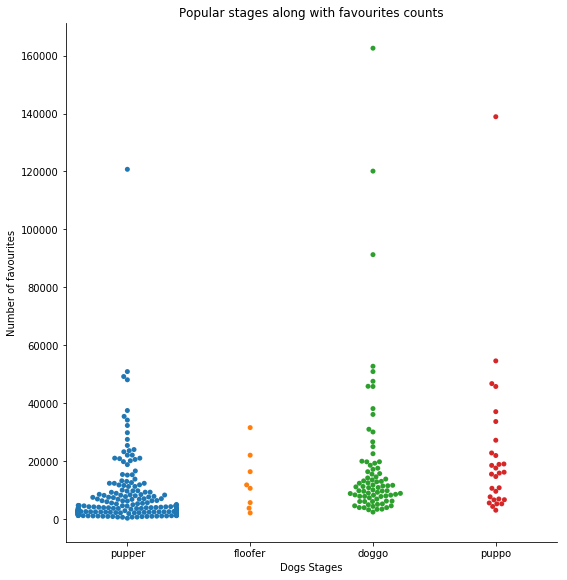

In [879]:
# Plot favourite_count per stage, in swarn

# visibility
myplot = sns.catplot(x="stacked_stages", y="favorite_count", kind="swarm", data=df_stages, height=8)
# Set the titles
myplot.set(title='Popular stages along with favourites counts', xlabel='Dogs Stages', ylabel='Number of favourites');

#### Insight 1 :
Beyond 80 000 favourites count, we have more doggo(3) than puppo(1) and pupper(1). So it seems that it is better be a doggo to the road to the success here !  


In [880]:
# Most stages in 2015
df_stages.query('timestamp > "2015-01-01 00:00:00" and timestamp <= "2016-01-01 00:00:00"')['stacked_stages'].value_counts()

pupper    73
Name: stacked_stages, dtype: int64

In [881]:
# Most stages in 2016
df_stages.query('timestamp > "2016-01-01 00:00:00" and timestamp <= "2017-01-01 00:00:00"')['stacked_stages'].value_counts()

pupper     138
doggo      46 
puppo      13 
floofer    6  
Name: stacked_stages, dtype: int64

Doggo stage appears in 2015, but the majority of the stages were still pupper.

In [882]:
# Most stages in 2017
df_stages.query('timestamp > "2017-01-01 00:00:00"')['stacked_stages'].value_counts()

doggo      33
pupper     22
puppo      16
floofer    2 
Name: stacked_stages, dtype: int64

Then doggo is on the rise.

#### Insight 2 :
Clearly we have more pupper pictures posted, because pupper pictures have been posted during 2015. This is strange, but might be linked to people awareness regarding the WeRateDogs twitter account, at the beginning.

Does the rating correlated to the most favorited ?

In [883]:
# Get the rating of the most favorited
df_most_favorited = df_stages.query('favorite_count > 80000')
df_most_favorited.rating.value_counts()

1.3    7
1.2    2
1.4    1
Name: rating, dtype: int64

In [884]:
# How is this rating positionned among all the others ?
df_master.describe()

,tweet_id,img_num,confidence,retweet_count,favorite_count,rating
count,2.075000e+03,2075.000000,2075.000000,1964.000000,1964.000000,1968.000000
mean,7.384514e+17,1.203855,0.547955,2625.843177,8642.184318,1.163556
std,6.785203e+16,0.561875,0.297842,4693.838058,12689.882348,4.090735
min,6.660209e+17,1.000000,0.000010,11.000000,77.000000,0.000000
25%,6.764835e+17,1.000000,0.299295,584.750000,1854.750000,1.000000
50%,7.119988e+17,1.000000,0.541780,1259.000000,3911.000000,1.100000
75%,7.932034e+17,1.000000,0.820962,3004.250000,10806.750000,1.200000
max,8.924206e+17,4.000000,1.000000,82678.000000,162549.000000,177.600000


#### Insight 3 :
The most favorited tweets (meaning images) are rated high, more than the rating and in the last quartile up to the highest rate.  
So, basically the most favorited tweets are highly rated, which is a normal expected situation here.

/Users/jlcossi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


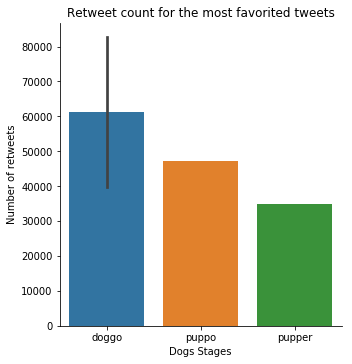

In [885]:
# Are they part of the most retweeted ?
retweetplot = sns.catplot(x="stacked_stages", y="retweet_count", kind="bar", data=df_most_favorited)
retweetplot.set(title='Retweet count for the most favorited tweets', xlabel='Dogs Stages', ylabel='Number of retweets');

#### Insight 4 : 
We observe this plot along with the statistics summary above. We confirm that the most favorited are well positioned within the most retweeted.

What are the breeds associated to the success ?

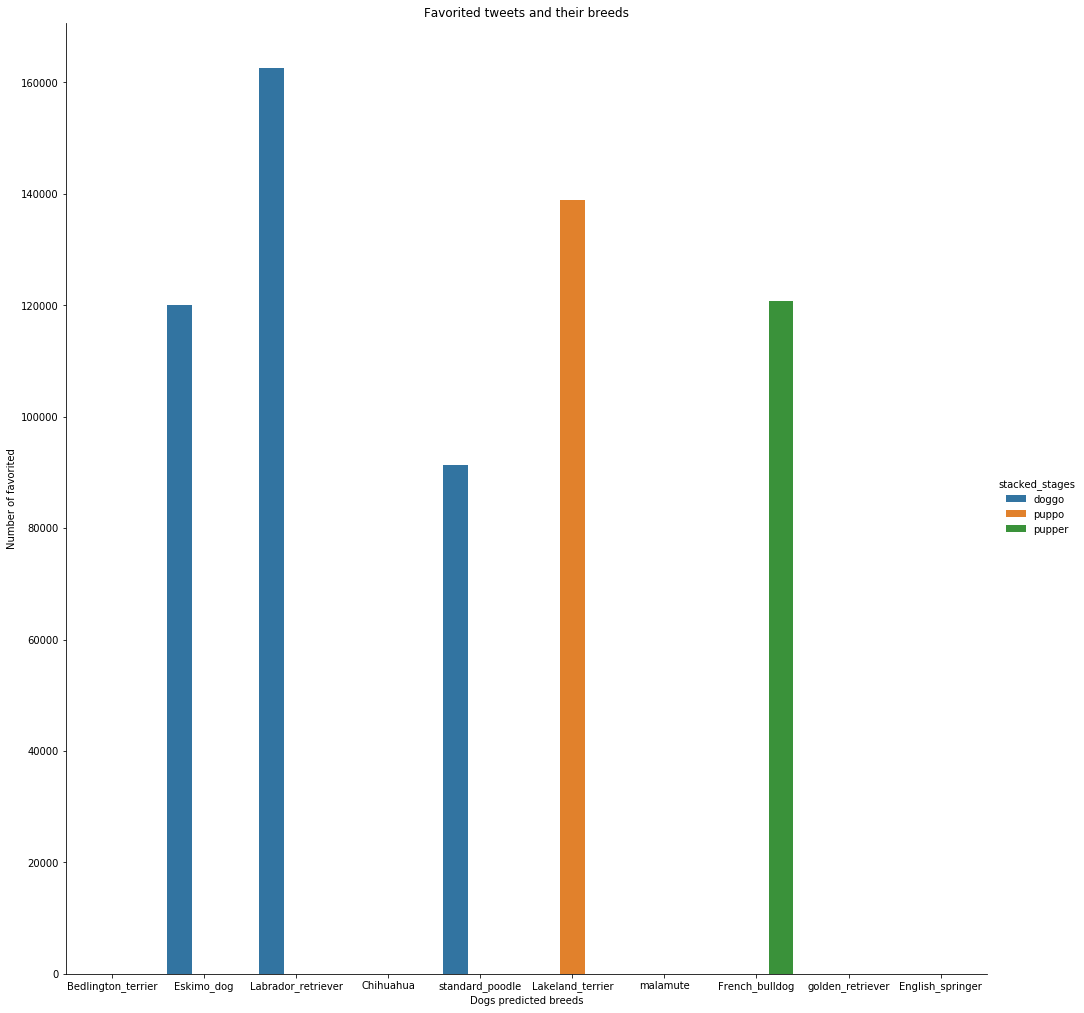

In [886]:
# Observe the breeds
breedplot = sns.catplot(x="prediction", y="favorite_count", hue="stacked_stages", kind="bar", data=df_most_favorited, height=14);
breedplot.set(title='Favorited tweets and their breeds', xlabel='Dogs predicted breeds', ylabel='Number of favorited');

We do not have all the stages for the identified breeds here.  
Even with this small limitation, we can conclude that being a Labrador_retriever, an Eskimo_dog, a standard_poodle and a doggo might lead to a chance to be part of the most favorited by WeRateDogs members.  

We observe in the dataset, that 2 of the 3 successful doggos were shared as videos. So this is an important factor because videos transmit emotions. 
So there might me other elements which are not in the scope of this study: colors and the quality of the images or videos.

In [887]:
# The favorited tweets, including the breeds
df_most_favorited

,tweet_id,jpg_url,img_num,prediction,confidence,detectiontype,timestamp,source,text,expanded_urls,name,stage,retweet_count,favorite_count,rating,stacked_stages
571,678399652199309312,https://pbs.twimg.com/ext_tw_video_thumb/678399528077250560/pu/img/BOjUNHRsYLeSo0hl.jpg,1,Bedlington_terrier,0.015047,dog,2015-12-20 02:20:55,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This made my day. 12/10 please enjoy https://t.co/VRTbo3aAcm,https://twitter.com/dog_rates/status/678399652199309312/video/1,None,None,33355.0,81543.0,1.2,NaN
1186,739238157791694849,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,1,Eskimo_dog,0.503372,dog,2016-06-04 23:31:25,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,https://twitter.com/dog_rates/status/739238157791694849/video/1,None,doggo,61211.0,120128.0,1.3,doggo
1221,744234799360020481,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,Labrador_retriever,0.825333,dog,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,None,doggo,82678.0,162549.0,1.3,doggo
1641,807106840509214720,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,1,Chihuahua,0.505370,dog,2016-12-09 06:17:20,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,https://twitter.com/dog_rates/status/807106840509214720/video/1,Stephan,None,60299.0,125650.0,1.3,NaN
1715,819004803107983360,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle,0.351308,dog,2017-01-11 02:15:36,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,Bo,doggo,39660.0,91294.0,1.4,doggo
1744,822872901745569793,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,Lakeland_terrier,0.196015,dog,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,https://twitter.com/dog_rates/status/822872901745569793/photo/1,None,puppo,47136.0,138899.0,1.3,puppo
1932,859196978902773760,https://pbs.twimg.com/ext_tw_video_thumb/859196962498805762/pu/img/-yBpr4-o4GJZECYE.jpg,1,malamute,0.216163,dog,2017-05-02 00:04:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,https://twitter.com/dog_rates/status/859196978902773760/video/1,quite,None,30403.0,89782.0,1.2,NaN
1961,866450705531457537,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,2,French_bulldog,0.905334,dog,2017-05-22 00:28:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",https://twitter.com/dog_rates/status/866450705531457537/photo/1,Jamesy,pupper,35037.0,120747.0,1.3,pupper
1977,870374049280663552,https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg,1,golden_retriever,0.841001,dog,2017-06-01 20:18:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She really likes 

In [888]:
# Generate the HTML version of this notebook
from subprocess import call
call(['python', '-m', 'nbconvert', 'Wrangle_act.ipynb'])

0